In [ ]:
# 1. wipe any previous checkout
!rm -rf DSA4213-group-project-travel-assistant-chatbot

# 2. fresh clone
!git clone https://github.com/dhyyunn/DSA4213-group-project-travel-assistant-chatbot.git

# 3. enter repo
%cd DSA4213-group-project-travel-assistant-chatbot

# 4. fetch all remote branches
!git fetch origin

# 5. checkout the branch you pushed (baseline-gemma2)
!git checkout baseline-gemma2


Cloning into 'DSA4213-group-project-travel-assistant-chatbot'...
remote: Enumerating objects: 310, done.
remote: Counting objects: 100% (22/22), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 310 (delta 13), reused 19 (delta 13), pack-reused 288 (from 1)
Receiving objects: 100% (310/310), 98.96 MiB | 15.58 MiB/s, done.
Resolving deltas: 100% (149/149), done.
/content/DSA4213-group-project-travel-assistant-chatbot/DSA4213-group-project-travel-assistant-chatbot
Branch 'baseline-gemma2' set up to track remote branch 'baseline-gemma2' from 'origin'.
Switched to a new branch 'baseline-gemma2'


In [ ]:
!pip install -q "transformers>=4.45.0" \
               "sentence-transformers>=2.2.2" \
               "faiss-cpu>=1.7.4" \
               "bitsandbytes>=0.43.1" \
               "huggingface_hub>=0.24.0" \
               gradio matplotlib pandas

from huggingface_hub import login
login()


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 77.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.1/60.1 MB 10.7 MB/s eta 0:00:00


In [ ]:
import sys, os
PROJECT_ROOT = os.path.abspath(".")
SRC_DIR = os.path.join(PROJECT_ROOT, "src")
if SRC_DIR not in sys.path:
    sys.path.append(SRC_DIR)

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SRC_DIR:", SRC_DIR)

from rag_functions import load_generator, load_faiss_index, rag_answer


PROJECT_ROOT: /content/DSA4213-group-project-travel-assistant-chatbot
SRC_DIR: /content/DSA4213-group-project-travel-assistant-chatbot/src
🔹 Initializing retriever, index, and corpus...
🔹 Loading BGE retriever...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/779 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/366 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

✅ Loading existing FAISS index and corpus...
✅ rag_functions.py ready.


# 1. Baseline Gemma2 Model

🔹 Loading model...


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1025: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


🔹 Loaded 10 evaluation queries.
🔹 Computing semantic similarity with BGE...
✅ Average similarity: 0.7829
💾 Results saved to reports/evaluation_gemma2_baseline.csv


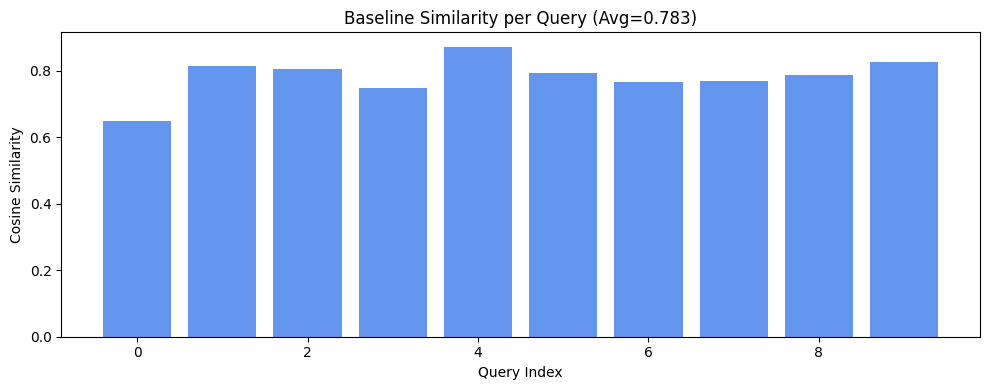

In [ ]:
import importlib, baseline_gemma2
importlib.reload(baseline_gemma2)

from baseline_gemma2 import evaluate_baseline

df_baseline = evaluate_baseline(
    data_path="data/evaluation_queries.csv",
    save_path="reports/evaluation_gemma2_baseline.csv"
)


# 2. gemma2 with Top-k RAG


In [14]:
import gc, torch
try: del generator
except: pass
try: del tokenizer
except: pass
try: del retriever
except: pass
torch.cuda.empty_cache()
gc.collect()


62184

In [15]:
import pandas as pd
from rag_functions import load_generator, load_faiss_index, rag_answer
from sentence_transformers import SentenceTransformer, util
from pathlib import Path

Path("reports").mkdir(exist_ok=True, parents=True)

# 1) download
retriever, index, corpus = load_faiss_index(
    index_path="data/faiss.index",
    corpus_path="data/corpus.json",
    data_path="data/wikivoyage_chunks.jsonl",
    sample_size=10_000
)
generator, tokenizer = load_generator()

# 2) read questions
df = pd.read_csv("data/evaluation_queries.csv")

# 3) RAG generation
def rag_generate(q):
    ans, ctx = rag_answer(
        q, retriever, index, corpus, generator, tokenizer,
        top_k=3, max_new_tokens=256, temperature=0.6, top_p=0.9
    )
    return ans, ctx

outs, ctxs = [], []
for q in df["query"].tolist():
    a, c = rag_generate(q)
    outs.append(a); ctxs.append(c)

df_out = df.copy()
df_out["generated_answer"] = outs
df_out["contexts"] = ctxs

# 4) similarity
encoder = SentenceTransformer("BAAI/bge-large-en-v1.5", device="cpu")
def sim(a, b):
    ea = encoder.encode(a, convert_to_tensor=True, device="cpu")
    eb = encoder.encode(b, convert_to_tensor=True, device="cpu")
    return float(util.cos_sim(ea, eb))

df_out["similarity"] = df_out.apply(lambda r: sim(r["generated_answer"], r["expected_answer"]), axis=1)
print("Average similarity (Top-k RAG):", df_out["similarity"].mean())

# 5) save CSV
df_out.to_csv("reports/evaluation_gemma2_RAG_topk.csv", index=False)


🔹 Loading BGE retriever...
✅ Loading existing FAISS index and corpus...


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1025: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


Average similarity (Top-k RAG): 0.6470747768878937


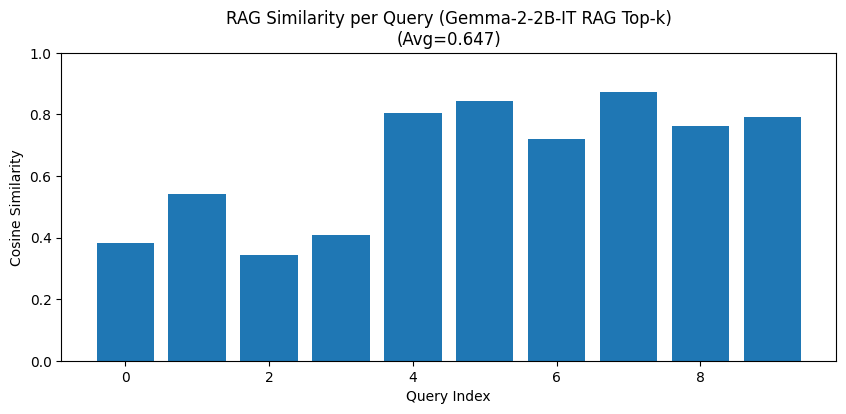

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,4))
plt.bar(range(len(df_out)), df_out["similarity"])

avg_sim = df_out["similarity"].mean()

plt.title(f"RAG Similarity per Query (Gemma-2-2B-IT RAG Top-k)\n(Avg={avg_sim:.3f})")
plt.xlabel("Query Index")
plt.ylabel("Cosine Similarity")

plt.ylim(0, 1.0)
plt.show()


In [19]:
import gc, torch
try: del generator
except: pass
try: del tokenizer
except: pass
try: del retriever
except: pass

torch.cuda.empty_cache()
gc.collect()


25638

# 4. gemma with rerank RAG

In [20]:
import pandas as pd
from pathlib import Path
from sentence_transformers import SentenceTransformer, util
import torch, gc
import importlib

import rag_functions
import rag_rerank_chatbot

importlib.reload(rag_functions)
importlib.reload(rag_rerank_chatbot)

from rag_functions import load_faiss_index, load_generator

🔹 Initializing retriever, index, and corpus...
🔹 Loading BGE retriever...
✅ Loading existing FAISS index and corpus...
✅ rag_functions.py ready.


In [21]:
# 1.
retriever, index, corpus = load_faiss_index(
    index_path="data/faiss.index",
    corpus_path="data/corpus.json",
    data_path="data/wikivoyage_chunks.jsonl",
    sample_size=10_000
)

# 2. download Gemma generator
generator, tokenizer = load_generator()

# 3. get questions
df_eval = pd.read_csv("data/evaluation_queries.csv")

rows = []
for q, gold in zip(df_eval["query"], df_eval["expected_answer"]):
    ans, used_ctxs = rag_rerank_chatbot.rag_rerank_answer(
        query=q,
        retriever=retriever,
        index=index,
        corpus=corpus,
        generator=generator,
        tokenizer=tokenizer,
        top_k=10,
        top_rerank=5,
    )
    rows.append({
        "query": q,
        "expected_answer": gold,
        "generated_answer": ans,
        "contexts": used_ctxs,
    })

df_rerank = pd.DataFrame(rows)


🔹 Loading BGE retriever...
✅ Loading existing FAISS index and corpus...


/usr/local/lib/python3.12/dist-packages/transformers/models/auto/tokenization_auto.py:1025: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/transformers/models/auto/auto_factory.py:492: FutureWarning: The `use_auth_token` argument is deprecated and will be removed in v5 of Transformers. Please use `token` instead.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [23]:
# 6. calculate similarity
encoder = SentenceTransformer("BAAI/bge-large-en-v1.5", device="cpu")

def cosine_sim(a, b):
    ea = encoder.encode(a, convert_to_tensor=True, device="cpu")
    eb = encoder.encode(b, convert_to_tensor=True, device="cpu")
    return float(util.cos_sim(ea, eb))

df_rerank["similarity"] = df_rerank.apply(
    lambda r: cosine_sim(r["generated_answer"], r["expected_answer"]),
    axis=1
)

avg_sim = df_rerank["similarity"].mean()
print("Average similarity (Gemma Reranked RAG):", avg_sim)

# 7. save CSV
Path("reports").mkdir(exist_ok=True, parents=True)
df_rerank.to_csv("reports/evaluation_gemma2_RAG_reranked.csv", index=False)
print("Saved to reports/evaluation_gemma2_RAG_reranked.csv")

Average similarity (Gemma Reranked RAG): 0.6177480012178421
Saved to reports/evaluation_gemma2_RAG_reranked.csv


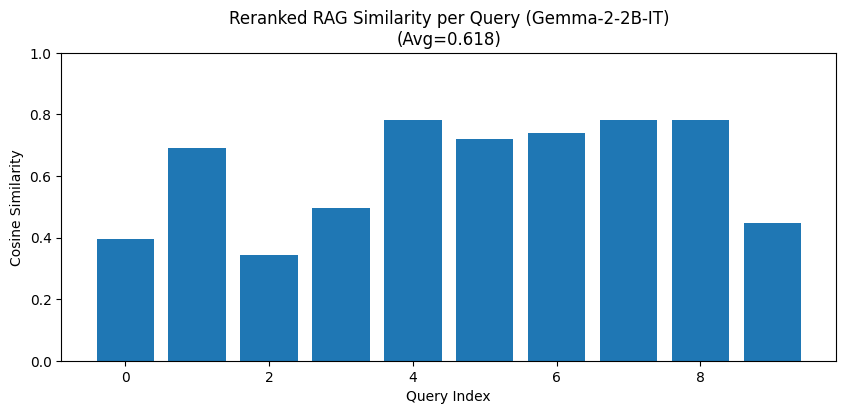

In [24]:
import matplotlib.pyplot as plt

avg_sim = df_rerank["similarity"].mean()

plt.figure(figsize=(10,4))

plt.bar(range(len(df_rerank)), df_rerank["similarity"])

plt.title(f"Reranked RAG Similarity per Query (Gemma-2-2B-IT)\n(Avg={avg_sim:.3f})")
plt.xlabel("Query Index")
plt.ylabel("Cosine Similarity")

plt.ylim(0, 1.0)
plt.show()


# 5. Comparison between Top-k and rerank RAG

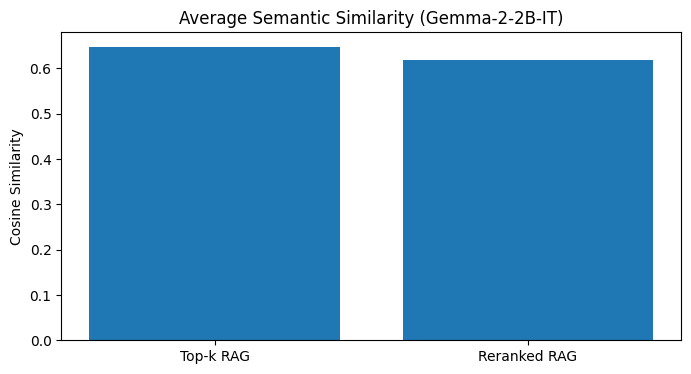

In [25]:
import pandas as pd
import matplotlib.pyplot as plt

df_topk = pd.read_csv("reports/evaluation_gemma2_RAG_topk.csv")
df_rer  = pd.read_csv("reports/evaluation_gemma2_RAG_reranked.csv")

plt.figure(figsize=(8,4))
plt.bar(["Top-k RAG", "Reranked RAG"],
        [df_topk["similarity"].mean(), df_rer["similarity"].mean()])
plt.title("Average Semantic Similarity (Gemma-2-2B-IT)")
plt.ylabel("Cosine Similarity")
plt.show()